# Machine Learning - I 
# Goodreads Book Ratings Prediction 
By - Ese Emuraye & Pragya Srivastava


## Introduction & Motivation

Personalization is one of the most important applications of data science. Businesses use machine learning techniques, supervised and unsupervised, to predict customer behavior to give their customers the best possible experience and thereby increase sales and customer retention and acquisition. Our motivation for this project was to bring in personalization in the area of book recommendations, using the Goodreads books dataset found [here](https://www.kaggle.com/zygmunt/goodbooks-10k). We were aiming to use method like user-based collaborative filtering, matrix factorization, K-means etc.

But due to extreme complexity and computational time of these methods, we simplified the problem statement and used the books dataset to predict average book ratings.

### Objective

The objective of this project is to predict the averag rating of a book

### Scope

This project involves the use of book features from the goodreads datasets to predict the average rating of a book. The average rating of a book ranges from 1 to 5. Several features from the books datasets and generated features have been explored to carry out a classification task



## Data Preprocessing

The section below covers getting the datasets and performing data cleaning to prepare the data in the right format for exploratory data analysis. The section ends with splitting the clean data into the training and test datasets

### Load Relevant Datasets & Libraries

In [1]:
# Load relevant libraries
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
sns.set(color_codes=True)

In [3]:
pd.set_option('display.max_rows',None)
import warnings
warnings.filterwarnings('ignore')

In [4]:
# set base path to datasets folder
dir_path = 'Data/'

# Load raw books dataset 
df_raw_books = pd.read_csv(dir_path + 'books.csv',header =0)
# Make a copy of df_raw_books
df_books = df_raw_books.copy(deep=True)

# Load raw books dataset 
df_raw_ratings = pd.read_csv(dir_path + 'ratings.csv',header = 0)
# Make a copy of df_raw_ratings
df_ratings = df_raw_ratings.copy(deep=True)

# Load raw books dataset 
df_raw_booktags = pd.read_csv(dir_path + 'book_tags.csv',header =0)
# Make a copy of df_raw_booktags
df_booktags = df_raw_booktags.copy(deep=True)

# Load raw books dataset 
raw_to_read_data = pd.read_csv(dir_path + 'to_read.csv',header=0)
# Make a copy of raw_to_read_data
to_read_data = raw_to_read_data.copy(deep=True)

# Load raw books dataset 
raw_tags = pd.read_csv(dir_path + 'tags.csv',header=0)
# Make a copy of raw_tags
tags = raw_tags.copy(deep=True)

In [5]:
# Print the dimension of df_ratings
pd.DataFrame([[df_ratings.shape[0], df_ratings.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,981756,3


In [6]:
# Print the dimension of df_booktags
pd.DataFrame([[df_booktags.shape[0], df_booktags.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,999912,3


In [7]:
# Print the first 5 rows of df_booktags
df_booktags.head()

,book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [8]:
# Print the first 5 rows of df_ratings
df_ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [9]:
# Display shapes from all datasets
print(df_books.shape)
print(df_ratings.shape)
print(df_booktags.shape)
print(to_read_data.shape)
print(tags.shape)

(10000, 23)
(981756, 3)
(999912, 3)
(912705, 2)
(34252, 2)


### Data Cleaning

In this sub-section, we look through each of the imported datasets and perform necessary cleaning operations. 

#### Clean Ratings Dataset

The total number of observation for the ratings datasets is approximately 1 million which is large. For the purpose of this project, we obtain a subsample of the ratings for use in our analysis.

In [10]:
# sort rating dataset by user_id and book_id
df_ratings = df_ratings.sort_values(by=['user_id','book_id'])

# construct key using combination of book_id and user_id
df_ratings['key']=df_ratings.book_id.astype(str)+df_ratings.user_id.astype(str)

# deduping ratings
df_ratings = df_ratings.drop_duplicates('key',keep='first')

df_ratings.shape

(979310, 4)

In [11]:
# create new column to store user count
df_ratings['user_count']= df_ratings.groupby(['user_id'])['book_id'].transform('count')

# filter user count greater than two
df_ratings = df_ratings.loc[df_ratings['user_count']>2]

In [12]:
# create a subsample of users for our analysis
users = df_ratings['user_id'].unique()
sample_users = users[0:9500]

df_ratings_samp = df_ratings.loc[df_ratings['user_id'].isin(sample_users)]

df_ratings_samp.shape

(214231, 5)

In [13]:
df_ratings_samp.set_index(["rating",'user_id']).count(level="rating")

,book_id,key,user_count
rating,,,
1,4138,4138,4138
2,16929,16929,16929
3,63925,63925,63925
4,80887,80887,80887
5,48352,48352,48352


##### Clean Tags Dataset

The tags datasets contain tags like 'to-read','fantasy','thriller' etc which can be useful for predicting book ratings. We peek into the datasets and clean tags in a format ready for analysis

In [14]:
#extracting tags from the tag name column
tags['tag_cleaned']=tags['tag_name'].str.extract(r"([a-z].*)", expand=False)

# print first five rows of tags dataset
tags.head()

,tag_id,tag_name,tag_cleaned
0,0,-,NaN
1,1,--1-,NaN
2,2,--10-,NaN
3,3,--12-,NaN
4,4,--122-,NaN


In [15]:
# merge extracted tags with the booktags dataset containing tag ids only, to get the actual tag in words
tags_data = pd.merge(df_booktags, tags, how='left', on='tag_id')

# print the shape of the merge tag dataset
tags_data.shape

(999912, 5)

In [16]:
# pick relevant columns from tags data
tags_data = tags_data[['book_id','count','tag_id','tag_cleaned']]

In [17]:
# selecting the tag with highest count of tags for each book
td = tags_data.sort_values(by=['book_id','count'],ascending=[1,0]).groupby('book_id').head(1)

td.head(10)

,book_id,count,tag_id,tag_cleaned
0,1,167697,30574,to-read
100,2,24549,30574,to-read
200,3,496107,30574,to-read
300,5,40087,11557,favorites
400,6,38378,11305,fantasy
500,8,2823,30574,to-read
600,10,3226,30574,to-read
700,11,32303,30574,to-read
800,13,75870,30574,to-read
900,21,33603,30574,to-read


#### Clean to_read Dataset
Similarly the 'to_read dataset' contains details about how many times a particular book has been put in the to_read list by users. Together with the tags dataset, we can create new features that will aid in our analysis

In [18]:
to_read_data.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [19]:
# final to-read dataset with counts for each book-id
trd = to_read_data.groupby('book_id').count()[['user_id']].reset_index()

# print the first five rows of the trd data frame
trd.head()

,book_id,user_id
0,1,973
1,2,400
2,3,287
3,4,1478
4,5,1293


#### Merge the datasets 

Merge all the datasets created above - tags data and to_read data- with the books datatset to create a final dataset with all features

In [20]:
from functools import reduce

# create dataframe and store all datasets in the dataframe
data_frames = [df_books,td[['tag_cleaned','book_id']],trd[['user_id','book_id']]]

book_data_final = reduce(lambda  left,right: pd.merge(left,right,on=['book_id'],
                                            how='left'), data_frames).fillna('0')

# Print the first five rows of the final dataset
book_data_final.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_cleaned,user_id
0,1,2767052,2767052,2792775,272,439023483,9.78044e+12,Suzanne Collins,2008,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,favorites,0
1,2,3,3,4640799,491,439554934,9.78044e+12,"J.K. Rowling, Mary GrandPré",1997,Harry Potter and the Philosopher's Stone,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,to-read,287
2,3,41865,41865,3212258,226,316015849,9.78032e+12,Stephenie Meyer,2005,Twilight,...,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,young-adult,0
3,4,2657,2657,3275794,487,61120081,9.78006e+12,Harper Lee,1960,To Kill a Mockingbird,...,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,classics,50
4,5,4671,4671,245494,1356,743273567,9.78074e+12,F. Scott Fitzgerald,1925,The Great Gatsby,...,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,classics,48


#### Further cleaning

Perform some further cleaning operations based on observed discrepancies in the final books datasets

In [21]:
## Rename user_id 
book_data_final = book_data_final.rename(columns={'user_id':'to_read_count'})

# create author count column which counts the number of authors for each book
book_data_final['author_count']=book_data_final['authors'].str.split(',').apply(len)

In [22]:
# select only those tags whose count is greater than twenty to number of labels present for one hot encoding our feature
s = book_data_final['tag_cleaned'].value_counts()

book_data_final['tag_cleaned'] = np.where(book_data_final['tag_cleaned'].isin(s.index[s > 20]), book_data_final['tag_cleaned'], 'other')

In [23]:
# select only those languages whose count is greater than twnety to number of labels present for one hot encoding our feature
t = book_data_final['language_code'].value_counts()

book_data_final['language_code'] = np.where(book_data_final['language_code'].isin(t.index[t > 20]), book_data_final['language_code'], 'other')

In [24]:
# convert relevant columns to integer for further use
book_data_final['original_publication_year'] = book_data_final['original_publication_year'].astype(int)
book_data_final['to_read_count'] = book_data_final['to_read_count'].astype(int)

### Split dataset into training and test dataset

In this section, we split our final dataset into training and test dataset, so we can keep our test data prior to further analysis and model training. It is important this step is carried out before exploratory data analysis to prevent introducing data snooping bias. 

In [25]:
# specify target variable
target = 'avg_rating'

In [26]:
# create target label by creating bins for average rating to have different classes
# create bins for ratings
bins = [1, 1.5, 2.5, 3.5, 4.5, 5]
labels = [1,2,3,4,5]
book_data_final['avg_rating'] = pd.cut(book_data_final['average_rating'], bins=bins, labels=labels)

In [27]:
book_data_final['avg_rating'].value_counts()

4    9516
3     354
5     129
2       1
1       0
Name: avg_rating, dtype: int64

In [28]:
# include only ratings for 3,4,5 because we have very few records for 1 and 2 based on ratings provided by users
book_data_final = book_data_final[book_data_final['avg_rating'] > 2]

In [29]:
# divide book_data_final into train and test datasets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(book_data_final, train_size=0.8, random_state=42, stratify=book_data_final[target])

In [30]:
# drop the target variable from the test set
df_test = df_test.drop(columns=target)

## Exploratory Data Analysis

### Book Ratings

We have used the ratings available in the book ratings dataset to get an idea of the distribution of ratings

In [31]:
df_ratings_samp.head()

,book_id,user_id,rating,key,user_count
117889,1180,1,4,11801,3
488112,4893,1,3,48931,3
625717,6285,1,4,62851,3
796318,8034,2,4,80342,3
875008,8855,2,5,88552,3


In [32]:
# get mean ratings for each user
mean_ur = df_ratings_samp.groupby('user_id').mean()[['rating']]
mean_ur = mean_ur.reset_index()

Text(0.5, 0, 'Average Rating')

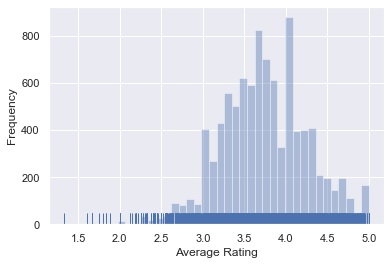

In [33]:
sns.distplot(mean_ur['rating'], kde=False, rug=True, bins=40);
plt.ylabel('Frequency')
plt.xlabel('Average Rating')

From the above plot we can see that most of the user ratings are towards 3.5 and above. There are very few ratings in the range of 1-3.

### Books Data

We further explore the training dataset to gain better understanding of the features in the dataset and their relationships

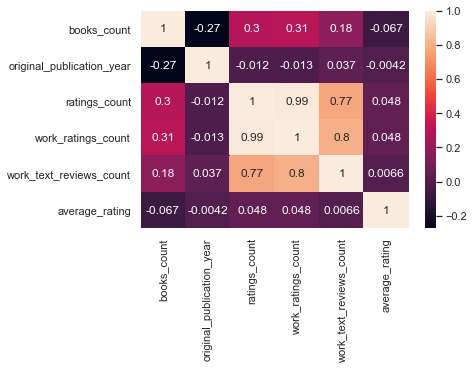

In [34]:
# plot a correlation matrix to show the relationship between numerical features
corrMatrix = df_train[['books_count','original_publication_year','ratings_count','work_ratings_count','work_text_reviews_count','average_rating']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [35]:
# define functions to make plots
def plot_scatter(df, x_label, y_label, chart_title):
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    sns.scatterplot(x=x_label, y=y_label, data=df, palette=cmap)
    plt.title(chart_title)
    
def plot_scatter_and_trendline(x, y, chart_title):
    sns.regplot(x,y)
    plt.title(chart_title)

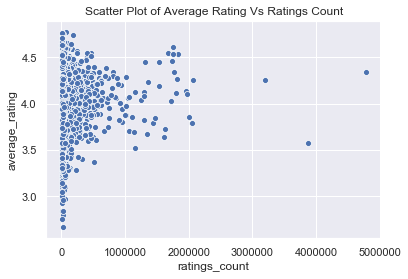

In [36]:
# make a scatter of average rating and ratings count
plot_scatter(df_train, 'ratings_count', 'average_rating', 'Scatter Plot of Average Rating Vs Ratings Count')

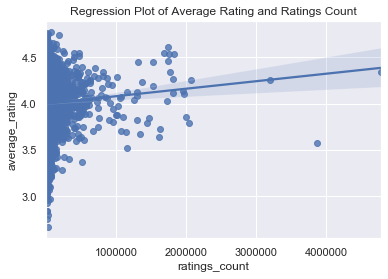

In [37]:
# make a regression plot of average rating and ratings count
plot_scatter_and_trendline(df_train['ratings_count'], df_train['average_rating'], 'Regression Plot of Average Rating and Ratings Count')

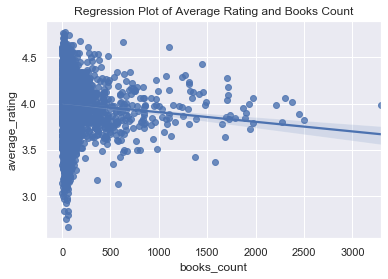

In [38]:
# make a regression plot of average rating and books count
plot_scatter_and_trendline(df_train['books_count'], df_train['average_rating'], 'Regression Plot of Average Rating and Books Count')

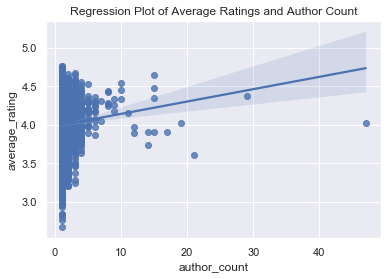

In [39]:
# make a regression plot of average rating and Authors count
plot_scatter_and_trendline(df_train['author_count'], df_train['average_rating'], 'Regression Plot of Average Ratings and Author Count')

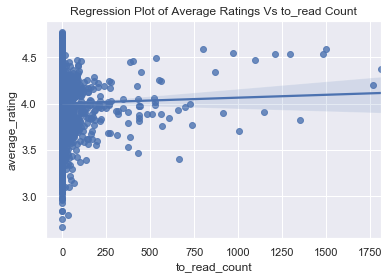

In [40]:
# make a regression plot of average rating and to_read count
df_train['to_read_count']= df_train['to_read_count'].astype(int)
plot_scatter_and_trendline(df_train['to_read_count'], df_train['average_rating'], 'Regression Plot of Average Ratings Vs to_read Count')

Text(0.5, 1.0, 'Bar Plot of Cleaned tags and Average Ratings')

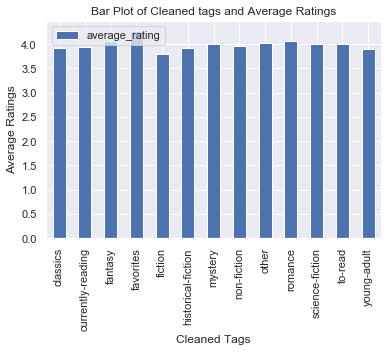

In [41]:
df_train.groupby('tag_cleaned').mean()[['average_rating']].plot(kind='bar')
plt.xlabel('Cleaned Tags')
plt.ylabel('Average Ratings')
plt.title('Bar Plot of Cleaned tags and Average Ratings')

## Preparation of Data for Machine Learning Prediction

### Dividing training data into training and validation dataset

In [42]:
from sklearn.model_selection import train_test_split

# Divide the training data into training (80%) and validation (20%)
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=42, stratify=df_train[target])

# Reset the index
df_train, df_valid = df_train.reset_index(drop=True), df_valid.reset_index(drop=True)

### Handling identifiers

#### Combining training, validation and test dataset

In [43]:
# Combine df_train, df_valid and df_test
df = pd.concat([df_train, df_valid, df_test], sort=False)

#### Identifying the identifiers

In [44]:
def id_checker(df):
    """
    The identifier checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of identifiers
    """
    
    # Get the identifiers
    df_id = df[[var for var in df.columns 
                if df[var].nunique(dropna=True) == df[var].notnull().sum()]]
                
    return df_id

In [45]:
# Call id_checker on df
df_id = id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

,id,book_id,best_book_id,work_id
0,2564,8647,8647,4088
1,8581,502295,502295,3352513
2,469,41899,41899,4195128
3,5651,17673307,17673307,24673151
4,5078,4758093,4758093,4822885


#### Removing the identifiers

In [46]:
# Remove the identifiers from df_train
df_train = df_train.drop(columns=df_id.columns)

# Remove the identifiers from df_valid
df_valid = df_valid.drop(columns=df_id.columns)

# Remove the identifiers from df_test
df_test = df_test.drop(columns=df_id.columns)

In [47]:
# Print the first 5 rows of df_train
df_train.head()

,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,...,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,tag_cleaned,to_read_count,author_count,avg_rating
0,34,1841492051,9.78184e+12,Orson Scott Card,2005,Shadow of the Giant,"Shadow of the Giant (Ender's Shadow, #4)",eng,3.98,37479,...,1795,9330,16805,13388,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read,20,1,4
1,19,316005274,9.78032e+12,"Jann S. Wenner, Corey Seymour",2007,Gonzo: The Life of Hunter S. Thompson,Gonzo: The Life of Hunter S. Thompson,en-US,4.07,9915,...,324,2117,3879,3710,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read,0,2,4
2,123,439321603,9.78044e+12,"Newt Scamander, J.K. Rowling, Albus Dumbledore",2001,Fantastic Beasts and Where to Find Them,Fantastic Beasts and Where to Find Them,eng,3.95,185928,...,13155,52573,64027,76863,https://images.gr-assets.com/books/1303738520m...,https://images.gr-assets.com/books/1303738520s...,other,0,3,4
3,11,0,0,Penny Reid,2013,Neanderthal Seeks Human,"Neanderthal Seeks Human (Knitting in the City,...",eng,3.96,29612,...,1635,6111,10828,10564,https://images.gr-assets.com/books/1364347894m...,https://images.gr-assets.com/books/1364347894s...,to-read,0,1,4
4,30,61767581,9.78006e+12,Lauren Conrad,2009,L.A. Candy,"L.A. Candy (L.A. Candy, #1)",en-US,3.36,21910,...,3587,8352,6128,4143,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,to-read,0,1,3


### Handling Missing Data

In [48]:
# Combine df_train, df_valid and df_test
df = pd.concat([df_train, df_valid, df_test], sort=False)

#### Identifying Missing Data

In [49]:
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and dtype
    """
    
    # Get the variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan

In [50]:
# Call nan_checker on df
df_nan = nan_checker(df)

# Print df_nan
df_nan

,var,proportion,dtype
0,avg_rating,0.20002,object


In [51]:
# Print the unique dtype of the variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

,dtype
0,object


In [52]:
# Get the variables with missing values, their proportion of missing values and dtype
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

,var,proportion,dtype


#### Removing missing values

In [53]:
# Remove rows with missing values from df_train
df_train = df_train.dropna(subset=np.intersect1d(df_miss['var'], df_train.columns),
                           inplace=False)

# Remove rows with missing values from df_valid
df_valid = df_valid.dropna(subset=np.intersect1d(df_miss['var'], df_valid.columns),
                           inplace=False)

# Remove rows with missing values from df_test
df_test = df_test.dropna(subset=np.intersect1d(df_miss['var'], df_test.columns),
                         inplace=False)

In [54]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,6399,23


In [55]:
# Print the dimension of df_valid
pd.DataFrame([[df_valid.shape[0], df_valid.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,1600,23


In [56]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,2000,22


### Remove irrelevant features

In [57]:
to_remove = ['isbn', 'isbn13', 'authors', 'original_title', 'title', 
             'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
            'image_url', 'small_image_url', 'average_rating', 'to_read_count']

In [58]:
# Remove rows with irrelevant columns from df_train
df_train = df_train.drop(columns=to_remove)

# Remove rows with irrelevant columns from df_valid
df_valid = df_valid.drop(columns=to_remove)

# Remove rows with irrelevant columns values from df_test
df_test = df_test.drop(columns=to_remove)

In [59]:
# Print the dimension of df_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,6399,9


In [60]:
# Print the dimension of df_valid
pd.DataFrame([[df_valid.shape[0], df_valid.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,1600,9


In [61]:
# Print the dimension of df_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,2000,8


### Encoding the data

#### Combining the training, validation and testing data


In [62]:
# Combine df_train, df_valid and df_test
df = pd.concat([df_train, df_valid, df_test], sort=False)

# Print the unique dtype of variables in df
pd.DataFrame(df.dtypes.unique(), columns=['dtype'])

,dtype
0,int64
1,int32
2,object


#### Identifying the Categorical Variables

In [63]:
def cat_var_checker(df):
    """
    The categorical variable checker

    Parameters
    ----------
    df: the dataframe
    
    Returns
    ----------
    The dataframe of categorical variables and their number of unique value
    """
    
    # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)]
                           for var in df.columns if df[var].dtype == 'object'],
                          columns=['var', 'nunique'])
    
    # Sort df_cat in accending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False).reset_index(drop=True)
    
    return df_cat

In [64]:
# Call cat_var_checker on df
df_cat = cat_var_checker(df)

# Print the dataframe
df_cat

,var,nunique
0,tag_cleaned,13
1,language_code,9
2,avg_rating,4


#### Encoding the categorical features


In [65]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,books_count,original_publication_year,ratings_count,work_ratings_count,work_text_reviews_count,author_count,avg_rating,language_code_0,language_code_ara,language_code_en-CA,...,tag_cleaned_favorites,tag_cleaned_fiction,tag_cleaned_historical-fiction,tag_cleaned_mystery,tag_cleaned_non-fiction,tag_cleaned_other,tag_cleaned_romance,tag_cleaned_science-fiction,tag_cleaned_to-read,tag_cleaned_young-adult
0,34,2005,37479,41690,885,1,4,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,19,2007,9915,10108,252,2,4,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,123,2001,185928,209465,6523,3,4,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,11,2013,29612,29949,3104,1,4,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,30,2009,21910,23402,2076,1,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [66]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode the categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

# Print the first 5 rows of df
df.head()

,books_count,original_publication_year,ratings_count,work_ratings_count,work_text_reviews_count,author_count,avg_rating,language_code_0,language_code_ara,language_code_en-CA,...,tag_cleaned_favorites,tag_cleaned_fiction,tag_cleaned_historical-fiction,tag_cleaned_mystery,tag_cleaned_non-fiction,tag_cleaned_other,tag_cleaned_romance,tag_cleaned_science-fiction,tag_cleaned_to-read,tag_cleaned_young-adult
0,34,2005,37479,41690,885,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,19,2007,9915,10108,252,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,123,2001,185928,209465,6523,3,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,11,2013,29612,29949,3104,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,30,2009,21910,23402,2076,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [67]:
df.head()

,books_count,original_publication_year,ratings_count,work_ratings_count,work_text_reviews_count,author_count,avg_rating,language_code_0,language_code_ara,language_code_en-CA,...,tag_cleaned_favorites,tag_cleaned_fiction,tag_cleaned_historical-fiction,tag_cleaned_mystery,tag_cleaned_non-fiction,tag_cleaned_other,tag_cleaned_romance,tag_cleaned_science-fiction,tag_cleaned_to-read,tag_cleaned_young-adult
0,34,2005,37479,41690,885,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,19,2007,9915,10108,252,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,123,2001,185928,209465,6523,3,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,11,2013,29612,29949,3104,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,30,2009,21910,23402,2076,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Separating the training, validation and testing data
The code below shows how to separate the training, validation and testing data.

In [68]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :].copy(deep=True)

# Separating the validation data
df_valid = df.iloc[df_train.shape[0]:df_train.shape[0] + df_valid.shape[0], :].copy(deep=True)

# Separating the testing data
df_test = df.iloc[df_train.shape[0] + df_valid.shape[0]:, :].copy(deep=True)

In [69]:
# Print the dimension of df_remove_train
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,6399,29


In [70]:
# Print the dimension of df_remove_valid
pd.DataFrame([[df_valid.shape[0], df_valid.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,1600,29


In [71]:
# Print the dimension of df_remove_test
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,2000,29


### Getting the name of the features

In [72]:
features = np.setdiff1d(df.columns, [target])

### Getting the feature matrix and target vector


In [73]:
# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
X_test = df_test[features].to_numpy()

# Get the target vector
y_train = df_train[target].astype(int).to_numpy()
y_valid = df_valid[target].astype(int).to_numpy()

### Scaling the data
The code below shows how to standardize the data (using sklearn StandardScaler).

In [74]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_valid = ss.transform(X_valid)

# Standardize the testing data
X_test = ss.transform(X_test)

## Hyperparameter Tuning and Model Selection

### Creating the dictionary of the models
In the dictionary:
the key is the acronym of the model
the value is the model

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42),
          'xgbc': XGBClassifier(seed=42),
          'mlpc': MLPClassifier(early_stopping=True, random_state=42)}

### Creating the dictionary of the pipelines
In the dictionary:

the key is the acronym of the model
the value is the pipeline, which, for now, only includes the model

In [76]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

## Hyperparameter tuning and model selection using Sklearn (0.22 or above)¶

### Getting the predefined split cross-validator

In [77]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

## Creating the dictionary of the parameter grids

In [78]:
param_grids = {}

The parameter grid for logistic regression
The hyperparameters we want to fine-tune are:

C
tol

In [79]:
# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

The parameter grid for decision tree
The hyperparameters we want to fine-tune are:

min_samples_split
min_samples_leaf
max_depth

In [80]:
# The grids for min_samples_split
min_samples_split_grids = [2, 30, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 30, 100]

# The grids for max_depth
max_depth_grids = range(1, 11)

# Update param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__max_depth': max_depth_grids}]

The parameter grid for random forest
The hyperparameters we want to fine-tune are:

min_samples_split
min_samples_leaf

In [81]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

The parameter grid for xgboost
The hyperparameters we want to fine-tune are:

eta
gamma
lambda


In [82]:
# The grids for eta
eta_grids = [10 ** i for i in range(-4, 1)]

# The grids for gamma
gamma_grids = [0, 10, 100]

# The grids for lambda
lambda_grids = [10 ** i for i in range(-4, 5)]

# Update param_grids
param_grids['xgbc'] = [{'model__eta': eta_grids,
                        'model__gamma': gamma_grids,
                        'model__lambda': lambda_grids}]

The parameter grid for multi-layer perceptron classifier
The hyperparameters we want to fine-tune are:

alpha
learning_rate_init

In [83]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-6, -1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-5, 0)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

Creating the directory for the cv results.

In [84]:
import os

# Make directory
directory = os.path.dirname('cv_results/')
if not os.path.exists(directory):
    os.makedirs(directory)

Hyperparameter Tuning

In [85]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=-1,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='cv_results/' + acronym + '.csv', index=False)

## Model Selection

In [86]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.952500,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
1,0.952500,"{'model__eta': 0.1, 'model__gamma': 0, 'model_...","(XGBClassifier(base_score=0.5, booster=None, c..."
2,0.951875,"{'model__alpha': 1e-06, 'model__learning_rate_...","(MLPClassifier(activation='relu', alpha=1e-06,..."
3,0.682500,"{'model__max_depth': 10, 'model__min_samples_l...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
4,0.511250,"{'model__C': 100, 'model__tol': 1e-06}","(LogisticRegression(C=100, class_weight='balan..."


## Plot the Feature Importance

In [87]:
import os

# Make directory
directory = os.path.dirname('figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [88]:
# Get the best_score, best_param and best_estimator obtained by GridSearchCV
best_score_bm, best_param_bm, best_estimator_bm = best_score_param_estimator_gs[0]

# Get the dataframe of feature and importance
df_fi_bm = pd.DataFrame(np.hstack((features.reshape(-1, 1), best_estimator_bm.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_bm in descending order of the importance
df_fi_bm = df_fi_bm.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_
df_fi_bm.head()

,Features,Importance
0,work_text_reviews_count,0.220777
1,books_count,0.192298
2,work_ratings_count,0.160301
3,ratings_count,0.15064
4,original_publication_year,0.140004


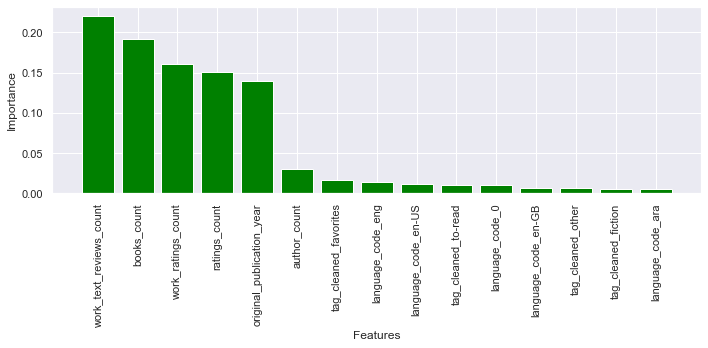

In [89]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# The bar plot of the top 15 feature importance
plt.bar(df_fi_bm['Features'][:15], df_fi_bm['Importance'][:15], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.savefig('figure/feature_importance_bm.pdf')
plt.show()

## Generating Prediction on Test data

In [90]:
# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_bm.predict(X_test)

# Transform y_test_pred back to the original class
y_test_pred = le.inverse_transform(y_test_pred)

# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((df_test[['ID_code']], y_test_pred.reshape(-1, 1))),
                         columns=['ID_code', target])

# Generate the submission file
df_submit.to_csv('submission.csv', index=False)

## Summary

In [91]:
# EDA

# Model

# Evaluation

# Best Metrics

# Feature Importance